# Feature Engineering

#### Import Package

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('../data/raw/ccm_rul_dataset.csv')
df.head()

,date,"workpiece_weight, tonn",steel_type,doc_requirement,cast_in_row,workpiece_slice_geometry,alloy_type,"steel_weight_theoretical, tonn","slag_weight_close_grab1, tonn","metal_residue_grab1, tonn",...,"Al, %","Ca, %","N, %","Pb, %","Mg, %","Zn, %",sleeve,num_crystallizer,num_stream,RUL
0,2020-01-05,144.9,Arm240,DOC 34028-2016,4,150x150,open,145.3,1.8,0.4,...,0.0022,0.0008,0.0085,0.0,0.0,0.0,30012261,22,4,384.0
1,2020-01-05,165.9,St3sp,Contract,10,150x150,open,166.3,1.8,0.4,...,0.0028,0.0004,0.0049,0.0,0.0,0.0,30013346,2,1,1037.0
2,2020-01-05,168.0,Arm240,DOC 34028-2016,5,150x150,open,168.4,1.8,0.4,...,0.0031,0.0011,0.0068,0.0,0.0,0.0,30012261,22,4,355.0
3,2020-01-05,170.1,St3sp,Contract,7,150x150,open,170.5,1.8,0.4,...,0.0034,0.0005,0.0051,0.0,0.0,0.0,30012261,22,4,300.0
4,2020-01-05,163.8,St3sp,Contract,12,150x150,open,164.2,1.8,0.4,...,0.0032,0.0004,0.0038,0.0,0.0,0.0,30012261,22,4,164.0


In [3]:
# Define equipment context (adjust if needed)
GROUP_COLS = ["num_crystallizer", "num_stream"]

df = df.sort_values(GROUP_COLS + ["date"])

#### Basic Derived Physical Features

#### Weight & Loss Features

In [4]:
df["steel_weight_error"] = (
    df["steel_weight, tonn"]
    - df["steel_weight_theoretical, tonn"]
)

df["total_residuals"] = (
    df["slag_weight_close_grab1, tonn"].fillna(0)
    + df["metal_residue_grab1, tonn"].fillna(0)
    + df["residuals_grab2, tonn"].fillna(0)
)

df["trim_ratio"] = (
    df["technical_trim, tonn"]
    / df["steel_weight, tonn"].replace(0, np.nan)
)


#### Thermal Delta & Gradient

In [5]:
df["temp_delta_measurement"] = (
    df["temperature_measurement2, Celsius deg."]
    - df["temperature_measurement1, Celsius deg."]
)

df["cooling_efficiency"] = (
    df["water_temperature_delta, Celsius deg."]
    / df["water_consumption, liter/minute"].replace(0, np.nan)
)


## Time-Aware Rolling Features (CORE PART)

In [6]:
ROLL_WINDOWS = [3, 5, 10]   # number of casts (can be tuned)

ROLL_COLS = [
    "steel_temperature_grab1, Celsius deg.",
    "water_temperature_delta, Celsius deg.",
    "alloy_speed, meter/minute",
    "swing_frequency, amount/minute",
    "resistance, tonn"
]

for col in ROLL_COLS:
    for w in ROLL_WINDOWS:
        df[f"{col}_roll_mean_{w}"] = (
            df
            .groupby(GROUP_COLS)[col]
            .transform(lambda x: x.rolling(w, min_periods=1).mean())
        )

        df[f"{col}_roll_std_{w}"] = (
            df
            .groupby(GROUP_COLS)[col]
            .transform(lambda x: x.rolling(w, min_periods=1).std())
        )


#### Approximate Local Slope (Finite Difference)

In [7]:
for col in [
    "steel_temperature_grab1, Celsius deg.",
    "water_temperature_delta, Celsius deg.",
    "alloy_speed, meter/minute"
]:
    df[f"{col}_diff"] = (
        df
        .groupby(GROUP_COLS)[col]
        .diff()
    )


#### Regime Encoding (Low Leakage)

In [8]:
# Cast position within a sequence
df["cast_position_norm"] = (
    df["cast_in_row"]
    / df.groupby(GROUP_COLS)["cast_in_row"].transform("max")
)


In [9]:
# Steel weight normalized by speed
df["weight_speed_ratio"] = (
    df["steel_weight, tonn"]
    / df["alloy_speed, meter/minute"].replace(0, np.nan)
)

#### Chemical Composition Aggregation (Dimensionality Control)

In [10]:
chem_cols = [c for c in df.columns if c.endswith(", %")]

df["chem_sum"] = df[chem_cols].sum(axis=1)
df["chem_std"] = df[chem_cols].std(axis=1)


In [11]:
carbon_group = ["C, %", "Mn,%", "Si, %"]
df["carbon_equivalent_proxy"] = df[carbon_group].sum(axis=1)

## Correlation Analysis (Post Feature Engineering)

In [12]:
num_cols = df.select_dtypes(include="number").columns

corr_rul = (
    df[num_cols]
    .corr()["RUL"]
    .drop("RUL")
    .sort_values()
)

corr_rul.head(15), corr_rul.tail(15)


(N, %                    -0.076428
 technical_trim, tonn    -0.070260
 trim_ratio              -0.068355
 Pb, %                   -0.054763
 Mg, %                   -0.043410
 Ti, %                   -0.042451
 V, %                    -0.039864
 Ce, %                   -0.039603
 Mo, %                   -0.036696
 residuals_grab2, tonn   -0.032326
 Zn, %                   -0.029748
 chem_sum                -0.029728
 chem_std                -0.028383
 Si, %                   -0.026824
 Nb, %                   -0.025975
 Name: RUL, dtype: float64,
 alloy_speed, meter/minute_roll_mean_10                         0.027430
 Ni, %                                                          0.029446
 water_consumption_secondary_cooling_zone_num1, liter/minute    0.031974
 swing_frequency, amount/minute_roll_std_3                      0.047604
 swing_frequency, amount/minute_roll_std_5                      0.055903
 swing_frequency, amount/minute_roll_std_10                     0.060633
 resistan

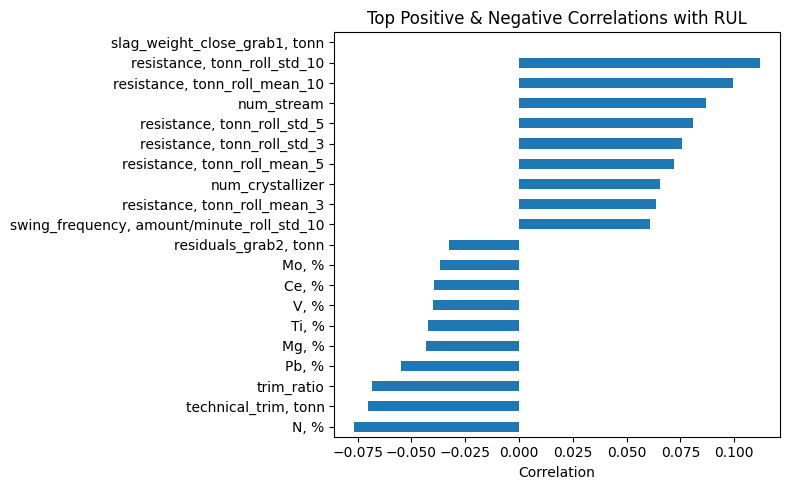

In [13]:
top_corr = pd.concat([
    corr_rul.head(10),
    corr_rul.tail(10)
])

plt.figure(figsize=(8, 5))
top_corr.plot(kind="barh")
plt.title("Top Positive & Negative Correlations with RUL")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


#### Multicollinearity Check (Optional but Recommended)

In [14]:
high_corr_pairs = (
    df[num_cols]
    .corr()
    .abs()
    .unstack()
    .reset_index()
)

high_corr_pairs = high_corr_pairs[
    (high_corr_pairs[0] > 0.9)
    & (high_corr_pairs["level_0"] != high_corr_pairs["level_1"])
]

high_corr_pairs.head(10)


,level_0,level_1,0
5,"workpiece_weight, tonn","steel_weight, tonn",0.917117
7,"workpiece_weight, tonn","technical_trim, tonn",0.927643
49,"workpiece_weight, tonn",trim_ratio,0.924946
175,cast_in_row,cast_position_norm,0.960548
185,"steel_weight_theoretical, tonn","steel_weight, tonn",0.982544
187,"steel_weight_theoretical, tonn","technical_trim, tonn",0.947203
229,"steel_weight_theoretical, tonn",trim_ratio,0.948123
407,"metal_residue_grab1, tonn",steel_weight_error,1.000000
450,"steel_weight, tonn","workpiece_weight, tonn",0.917117
452,"steel_weight, tonn","steel_weight_theoretical, tonn",0.982544


#### Feature Set Output (Clean & Model-Ready)

In [15]:
TARGET = "RUL"

DROP_COLS = [
    "date"
]

X = df.drop(columns=DROP_COLS + [TARGET])
y = df[TARGET]

X.shape, y.shape

((17503, 98), (17503,))